In [ ]:
##PART 1 OF CODE (OPTIMIZING PARAMETERS FROM DATASET)

import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize

# differential equations for SEIR model
def seir_model(y, t, beta, sigma, gamma, N):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

# loading + cleaning COVID-19 data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
data = pd.read_csv(url)
country_data = data[data['Country/Region'] == 'US'].iloc[:, 4:].sum(axis=0)
country_data.index = pd.to_datetime(country_data.index, format='%m/%d/%y', errors='coerce')
country_data = country_data.dropna()

# calculate daily cases and normalize by population size
N = 331002651  # US population
daily_cases = country_data.diff().fillna(0).values

# initializing conditions
I0 = daily_cases[0]
E0 = I0 * 2
R0 = 0
S0 = N - E0 - I0 - R0
initial_conditions = (S0, E0, I0, R0)

# time points
t = np.arange(len(daily_cases))

# objective function to minimize
def objective(params):
    beta, sigma, gamma = params
    solution = odeint(seir_model, initial_conditions, t, args=(beta, sigma, gamma, N))
    I = solution[:, 2]  # Infected individuals
    return np.sum((I - daily_cases) ** 2)

# initial guesses for parameters
initial_guess = [0.5, 1/5.2, 1/14]

# parameter bounds
bounds = [(0.0001, 1), (1/14, 1), (1/21, 1)]

# optimizing
result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
beta_opt, sigma_opt, gamma_opt = result.x

# displaying the results
print(f'Estimated Parameters:\nBeta: {beta_opt}\nSigma: {sigma_opt}\nGamma: {gamma_opt}')


Estimated Parameters:
Beta: 0.5
Sigma: 0.1923076923076923
Gamma: 0.07142857142857142


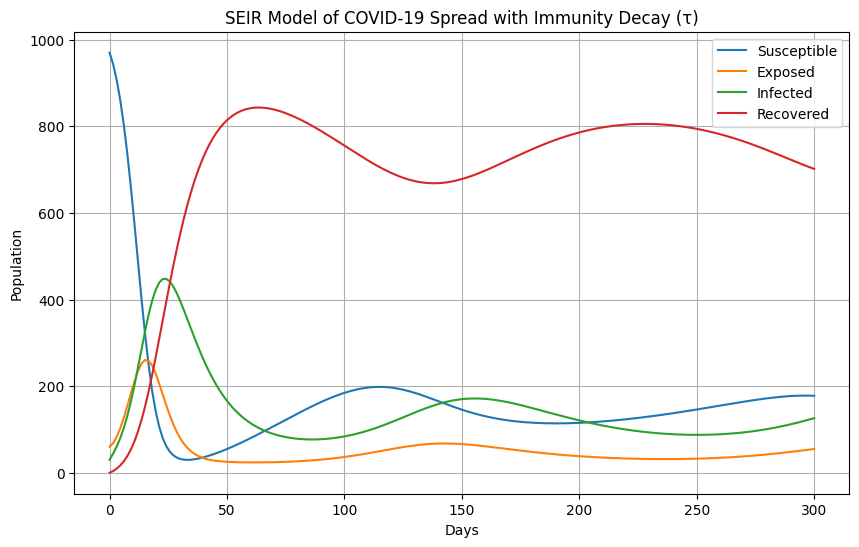

In [ ]:
##PART2 OF CODE (POST TAU IMPLEMENTATION)

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random

# parameters
population = 1000
initial_infected = 30
initial_exposed = 60
initial_recovered = 0
initial_susceptible = population - initial_infected - initial_recovered

# time-varying tau function
def tau_func(t):
    return 90 + 30 * np.sin(2 * np.pi * t / 180)

# diff eqa for the S.E.I.R model
def seir_model_with_immunity_decay(t, y, beta, sigma, gamma, population):
    S, E, I, R = y
    tau_t = tau_func(t)  # Dynamic tau value

    dS_dt = -beta * S * I / population + R / tau_t
    dE_dt = beta * S * I / population - sigma * E
    dI_dt = sigma * E - gamma * I
    dR_dt = gamma * I - R / tau_t
    return [dS_dt, dE_dt, dI_dt, dR_dt]

# parameters for SEIR model (set to the optimized parameters from previous code)
beta = beta_opt
sigma = sigma_opt
gamma = gamma_opt

# initial conditions
initial_conditions = [initial_susceptible, initial_exposed, initial_infected, initial_recovered]

# time (in days)
t_span = (0, 300)
t_eval = np.linspace(t_span[0], t_span[1], 200)

# solving ODE system
solution = solve_ivp(
    seir_model_with_immunity_decay,
    t_span,
    initial_conditions,
    args=(beta, sigma, gamma, population),
    t_eval=t_eval
)
S, E, I, R = solution.y

# plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t_eval, S, label='Susceptible')
plt.plot(t_eval, E, label='Exposed')
plt.plot(t_eval, I, label='Infected')
plt.plot(t_eval, R, label='Recovered')
plt.title('SEIR Model of COVID-19 Spread with Immunity Decay (τ)')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.show()

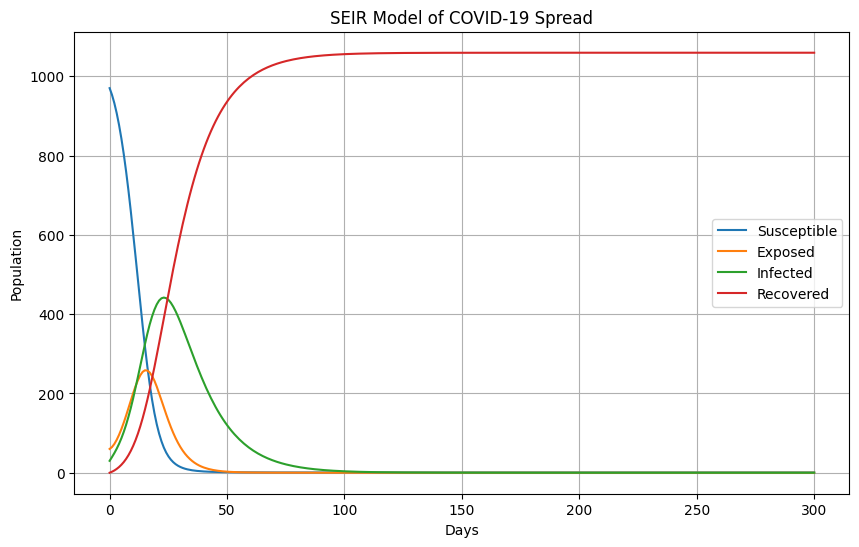

In [ ]:
##PRE TAU IMPLEMENTATION

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random


# parameters
population = 1000
initial_infected = 30
initial_exposed = 60
initial_recovered = 0
initial_susceptible = population - initial_infected - initial_recovered

# differential equations with immunity decay for SEIR model
def seir_model_with_immunity_decay(t, y, beta, sigma, gamma, population):
    S, E, I, R = y
    dS_dt = -beta * S * I / population
    dE_dt = beta * S * I / population - sigma * E
    dI_dt = sigma * E - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dE_dt, dI_dt, dR_dt]

# parameters for SEIR model
beta = beta_opt
sigma = sigma_opt
gamma = gamma_opt

# initial conditions
initial_conditions = [initial_susceptible, initial_exposed, initial_infected, initial_recovered]

# time (in days)
t_span = (0, 300)
t_eval = np.linspace(t_span[0], t_span[1], 300)

# solving ODE system
solution = solve_ivp(seir_model_with_immunity_decay, t_span, initial_conditions, args=(beta, sigma, gamma, population), t_eval=t_eval)
S, E, I, R = solution.y

# plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t_eval, S, label='Susceptible')
plt.plot(t_eval, E, label='Exposed')
plt.plot(t_eval, I, label='Infected')
plt.plot(t_eval, R, label='Recovered')
plt.title('SEIR Model of COVID-19 Spread')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.show()
